In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.metrics import fbeta_score, precision_score, recall_score, average_precision_score, confusion_matrix, accuracy_score

# Read Allerhande Dataset

In [3]:
df = pd.read_csv('./data/allerhande_clean.csv', low_memory=False)
df["tags"] = df["tags"].map(lambda d : ast.literal_eval(d)) #set type
df = df.dropna(subset=['tag_0'])
df = df.dropna(subset=['description'])

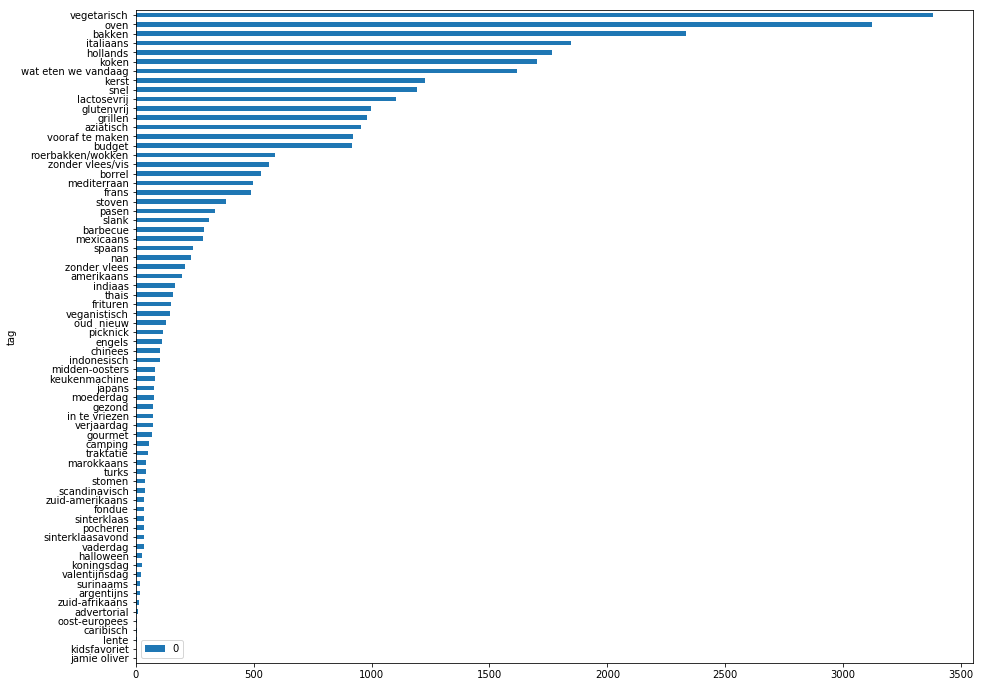

In [4]:
#show tags in dataset
all_tags = [item.strip() for sublist in list(df['tags_str'].astype(str).apply(lambda row: row.split(", ")).values) for item in sublist]
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(15,12))
plt.gca().invert_yaxis()

# Train on full set of tags

In [8]:
mlb = MultiLabelBinarizer()
df_tags_matrix = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_, index=df.index)

#for col in df_tags_matrix.columns:
#    if df_tags_matrix[col].sum() < 50:
#        df_tags_matrix.drop(col, axis=1, inplace=True)

#df_tags_matrix['gezond'] = df_tags_matrix['slank'] + df_tags_matrix['gezond']
#df_tags_matrix['vegetarisch'] = df_tags_matrix['vegetarisch'] + df_tags_matrix['zonder vlees/vis']
#df_tags_matrix['gezond'] = df_tags_matrix['gezond'].apply(lambda x: 1 if x >= 1 else 0)
#df_tags_matrix['vegetarisch'] = df_tags_matrix['vegetarisch'].apply(lambda x: 1 if x >= 1 else 0)

#drop_cols = ['oud  nieuw', 'pasen', 'verjaardag', 'moederdag', 'traktatie','in te vriezen', 'gourmet', 'keukenmachine',
#            'picknick', 'camping', 'wat eten we vandaag', 'kerst', 'vooraf te maken', 'zonder vlees/vis', 'zonder vlees']

#df_tags_matrix.drop(drop_cols, axis=1, inplace=True)
df.recipe_instruction = df.recipe_instruction.fillna('')
df_tags_matrix['text'] = df.title + ' ' + df.description + ' ' + df.recipe_instruction
df_tags_matrix = df_tags_matrix.dropna()

In [13]:
X = df_tags_matrix['text'] #set X variable combination of title and description fields 
y = df_tags_matrix.drop(['text'], axis=1).as_matrix()
#y = df_tags_matrix
print(X.shape, y.shape)
# shuffle and make training and test set
X_shuf, y_shuf = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y_shuf, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13594,) (13594, 69)
(9515,) (4079,) (9515, 69) (4079, 69)


In [21]:
clf = Pipeline([('tfidf', TfidfVectorizer(min_df=5, max_df=0.7, sublinear_tf=True, ngram_range=(1,2), analyzer='word', max_features=10000)),
                ('clf-svm', OneVsRestClassifier(LinearSVC(class_weight='balanced', C=1.0, verbose=True)))])

# fit classifier
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [24]:
predictions = clf.predict(X_test)
accuracy_score(y_test,predictions)

0.15592056876685462

In [26]:
score = fbeta_score(y_test, predictions, beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]]

/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Average F2 test score 0.5749960543887301
F2 test scores per tag:


/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[('italiaans', 0.85445329471397546),
 ('thais', 0.85365853658536583),
 ('vegetarisch', 0.84973166368515218),
 ('scandinavisch', 0.83333333333333337),
 ('hollands', 0.82283314242077144),
 ('aziatisch', 0.81715716969317465),
 ('spaans', 0.79268292682926855),
 ('oven', 0.77136752136752129),
 ('frans', 0.73793103448275865),
 ('indiaas', 0.73308270676691722),
 ('chinees', 0.7142857142857143),
 ('mexicaans', 0.70469798657718119),
 ('borrel', 0.69570871261378409),
 ('japans', 0.64356435643564358),
 ('indonesisch', 0.61688311688311703),
 ('mediterraan', 0.58176100628930816),
 ('wat eten we vandaag', 0.56175452096960377),
 ('oost-europees', 0.55555555555555558),
 ('turks', 0.55555555555555558),
 ('lactosevrij', 0.55555555555555547),
 ('bakken', 0.51254383598597253),
 ('koken', 0.5121245023525155),
 ('engels', 0.49549549549549543),
 ('grillen', 0.49277266754270704),
 ('midden-oosters', 0.46728971962616822),
 ('snel', 0.45797684952189233),
 ('stoven', 0.45669291338582679),
 ('kerst', 0.4396728016

# Engineer those features


In [368]:
df = pd.read_csv('./data/allerhande_clean.csv', low_memory=False)
df["tags"] = df["tags"].map(lambda d : ast.literal_eval(d)) #set type
df = df.dropna(subset=['tag_0'])
df = df.dropna(subset=['description'])

mlb = MultiLabelBinarizer()
df_tags_matrix = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_, index=df.index)


df_tags_matrix['gezond'] = df_tags_matrix['slank'] + df_tags_matrix['gezond']
df_tags_matrix['vegetarisch'] = df_tags_matrix['vegetarisch'] + df_tags_matrix['zonder vlees/vis'] + df_tags_matrix['veganistisch']
df_tags_matrix['gezond'] = df_tags_matrix['gezond'].apply(lambda x: 1 if x >= 1 else 0)
df_tags_matrix['vegetarisch'] = df_tags_matrix['vegetarisch'].apply(lambda x: 1 if x >= 1 else 0)

drop_cols = ['advertorial', 'koningsdag','in te vriezen', 'slank', 'lente', 'halloween', 'zuid-afrikaans',
             'oost-europees', 'picknick', 'kidsfavoriet', 'jamie oliver', 'caribisch',
             'camping', 'surinaams', 'vaderdag', 'valentijnsdag', 'argentijns', 'sinterklaas', 'pocheren',
            'verjaardag', 'traktatie', 'stomen', 'keukenmachine', 'zuid-amerikaans', 'veganistisch' ,'wat eten we vandaag',
            'moederdag']

df_tags_matrix.drop(drop_cols, axis=1, inplace=True)

for col in df_tags_matrix.columns:
    if df_tags_matrix[col].sum() < 50:
        df_tags_matrix.drop(col, axis=1, inplace=True)
        
stop_words = ['indiaas', 'indiase', 'vegetarisch', 'italiaans', 'thais', 'thaise', 'hollands',
    'hollandse', 'franse', 'frans', 'oven', 'borrel', 'aziatische', 'aziatisch', 'borrel',
    'mediterraanse', 'chinees', 'chinese', 'spaanse', 'spaanse', 'bakken', 'grillen', 
    'mexicaans', 'mexicaanse', 'glutenvrij', 'glutenvrije', 'lactosevrij', 'lactosevrije',
    'snel', 'amerikaans', 'amerikaanse', 'barbecue', 'indonesisch', 'indonesische', 
    'roerbakken/wokken', 'vooraf te maken', 'frituren', 'kerst', 'stoven', 'midden-oosters',
    'zonder vlees/vis', 'japans', 'japanse', 'budget', 'engels', 'engelse', 'gezond',
    'oud  nieuw', 'pasen', 'zonder vlees', 'gourmet']



df.recipe_instruction = df.recipe_instruction.fillna('')
df_tags_matrix['text'] = df.title + ' ' + df.description + ' ' + df.recipe_instruction
df_tags_matrix['text_without_stopwords'] = df_tags_matrix['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

df_tags_matrix = df_tags_matrix.dropna()
mlb.classes_ = df_tags_matrix.columns[:-1]

In [369]:
X = df_tags_matrix['text_without_stopwords'] #set X variable combination of title and description fields 
y = df_tags_matrix.drop(['text', 'text_without_stopwords'], axis=1).as_matrix()
#y = df_tags_matrix
print(X.shape, y.shape)
# shuffle and make training and test set
X_shuf, y_shuf = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y_shuf, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13594,) (13594, 37)
(9515,) (4079,) (9515, 37) (4079, 37)


In [370]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = Pipeline([('tfidf', TfidfVectorizer(min_df=0, max_df=0.25, ngram_range=(1,3), analyzer='word')),
                ('clf-svm', OneVsRestClassifier(LinearSVC(class_weight='balanced', C=1.0, verbose=True)))])

# fit classifier
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [371]:
predictions = clf.predict(X_test)
accuracy_score(y_test,predictions)

0.17872027457710224

In [372]:
score = fbeta_score(y_test, predictions, beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.4957665341978694
F2 test scores per tag:


/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[('vegetarisch', 0.82659987071751762),
 ('oven', 0.7892356399819086),
 ('spaans', 0.72347266881028938),
 ('italiaans', 0.71480144404332135),
 ('borrel', 0.69424964936886402),
 ('aziatisch', 0.66818774445893103),
 ('mediterraan', 0.5357142857142857),
 ('hollands', 0.51996836694345594),
 ('mexicaans', 0.50531914893617025),
 ('bakken', 0.49452133794694353),
 ('indiaas', 0.46948356807511737),
 ('grillen', 0.44321329639889201),
 ('thais', 0.43478260869565222),
 ('koken', 0.41856060606060613),
 ('snel', 0.38722442057659695),
 ('lactosevrij', 0.38533834586466165),
 ('roerbakken/wokken', 0.38145539906103293),
 ('stoven', 0.34552845528455284),
 ('zonder vlees', 0.32520325203252032),
 ('midden-oosters', 0.3125),
 ('vooraf te maken', 0.27824620573355818),
 ('glutenvrij', 0.27476500361532902),
 ('zonder vlees/vis', 0.27152317880794707),
 ('frituren', 0.26315789473684209),
 ('kerst', 0.24118738404452691),
 ('barbecue', 0.18716577540106957),
 ('indonesisch', 0.17751479289940827),
 ('frans', 0.164576

In [373]:
all_predicted_tags = []
for index in range(predictions.shape[0]):
    all_predicted_tags.append(', '.join(list(mlb.classes_[np.where(predictions[index, :] == 1)[0]])))
for x in all_predicted_tags:
    if x is None:
        x = ''
        
#for some reason inverse transform would not work after I removed some of the tags. 
original_tags = []
for index in range(y_test.shape[0]):
    original_tags.append(', '.join(list(mlb.classes_[np.where(y_test[index, :] == 1)[0]])))
original_tags[0:20]

['barbecue, grillen, vegetarisch',
 'kerst',
 'aziatisch, chinees, koken',
 'koken, vooraf te maken',
 'hollands, oven',
 'kerst, oven, vooraf te maken',
 'bakken',
 'glutenvrij, oven, vegetarisch, zonder vlees/vis',
 'mediterraan, snel',
 'glutenvrij, oven',
 'aziatisch, snel, thais',
 'italiaans, oven, vegetarisch',
 'grillen',
 'bakken, vegetarisch',
 'bakken',
 'italiaans, kerst, roerbakken/wokken',
 'bakken, italiaans',
 'glutenvrij, hollands, vegetarisch, zonder vlees/vis',
 'pasen, vegetarisch',
 '']

In [374]:
print(predictions.shape)
print(y_test.shape)
print(len(all_predicted_tags))
print(len(original_tags))

(4079, 37)
(4079, 37)
4079
4079


In [375]:
pred_df = pd.DataFrame({'id':X_test.index, 'description':X_test.values, 'predict_tag': all_predicted_tags, 'tag': original_tags})

In [376]:
pred_df[pred_df.predict_tag.str.contains('oud  nieuw')]

,description,id,predict_tag,tag
1486,"Cranberry mule Cocktail van gemberbier, wodka,...",12989,"borrel, glutenvrij, kerst, lactosevrij, oud n...","borrel, kerst, oud nieuw"
1662,Fiero-spritz Een lekker recept. Het drankje me...,7249,"borrel, oud nieuw",borrel
3148,Rodevruchtenmocktail met granaatappelpitjes Al...,5124,"borrel, glutenvrij, kerst, lactosevrij, oud n...","borrel, kerst, oud nieuw"


In [ ]:
#export predictions to csv
#pred_df.to_csv('pred_csv.csv')

# Train classifier using model trained on server

script: classifer-tags.py
output described in out_tag_classifier.txt

Best Params: ```
{'tfidf__min_df': 0, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 5), 'tfidf__max_features': None}
```

In [97]:
df = pd.read_csv('./data/allerhande_clean.csv', low_memory=False)
df["tags"] = df["tags"].map(lambda d: ast.literal_eval(d))
df = df.dropna(subset=['tag_0'])
df = df.dropna(subset=['description'])

# Transfer tags into dummy matrix
mlb = MultiLabelBinarizer()
df_tags_matrix = pd.DataFrame(mlb.fit_transform(df['tags']),
                              columns=mlb.classes_, index=df.index)


df_tags_matrix['gezond'] = df_tags_matrix['slank'] + df_tags_matrix['gezond']
df_tags_matrix['vegetarisch'] = df_tags_matrix['vegetarisch'] + df_tags_matrix['zonder vlees/vis'] + df_tags_matrix['veganistisch']
df_tags_matrix['gezond'] = df_tags_matrix['gezond'].apply(lambda x: 1 if x >= 1 else 0)
df_tags_matrix['vegetarisch'] = df_tags_matrix['vegetarisch'].apply(lambda x: 1 if x >= 1 else 0)

drop_cols = ['advertorial', 'koningsdag', 'in te vriezen', 'slank', 'lente', 'halloween', 'zuid-afrikaans',
             'oost-europees', 'picknick', 'kidsfavoriet', 'jamie oliver', 'caribisch',
             'camping', 'surinaams', 'vaderdag', 'valentijnsdag', 'argentijns', 'sinterklaas', 'pocheren',
            'verjaardag', 'traktatie', 'stomen', 'keukenmachine', 'zonder vlees/vis', 'zuid-amerikaans', 'veganistisch' ,'wat eten we vandaag',
            'moederdag']

df_tags_matrix.drop(drop_cols, axis=1, inplace=True)

for col in df_tags_matrix.columns:
    if df_tags_matrix[col].sum() < 50:
        df_tags_matrix.drop(col, axis=1, inplace=True)

stop_words = ['indiaas', 'indiase', 'vegetarisch', 'italiaans', 'thais', 'thaise', 'hollands',
    'hollandse', 'franse', 'frans', 'oven', 'borrel', 'aziatische', 'aziatisch', 'borrel',
    'mediterraanse', 'chinees', 'chinese', 'spaanse', 'spaanse', 'bakken', 'grillen', 
    'mexicaans', 'mexicaanse', 'glutenvrij', 'glutenvrije', 'lactosevrij', 'lactosevrije',
    'snel', 'amerikaans', 'amerikaanse', 'barbecue', 'indonesisch', 'indonesische', 
    'roerbakken/wokken', 'vooraf te maken', 'frituren', 'kerst', 'stoven', 'midden-oosters',
    'zonder vlees/vis', 'japans', 'japanse', 'budget', 'engels', 'engelse', 'gezond',
    'oud  nieuw', 'pasen', 'zonder vlees', 'gourmet']



df.recipe_instruction = df.recipe_instruction.fillna('')
df_tags_matrix['text'] = df.title + ' ' + df.description + ' ' + df.recipe_instruction

df_tags_matrix['text_without_stopwords'] = df_tags_matrix['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))


df_tags_matrix = df_tags_matrix.dropna()
mlb.classes_ = df_tags_matrix.columns[:-2]

X = df_tags_matrix['text_without_stopwords']
y = df_tags_matrix.drop(['text', 'text_without_stopwords'], axis=1).as_matrix()
print(X.shape, y.shape)
# shuffle and make training and test set
X_shuf, y_shuf = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y_shuf, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13594,) (13594, 36)
(9515,) (4079,) (9515, 36) (4079, 36)


In [47]:
from sklearn.externals import joblib
tag_clf = joblib.load('models/clf_tags_no_stop.pkl')

In [48]:
predictions = tag_clf.predict(X_test)

In [49]:
print("Accuracy Score: {}".format(accuracy_score(y_test, predictions)))

Accuracy Score: 0.7447903898014219


In [50]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, predictions)

0.014198741521614775

In [52]:
score = fbeta_score(y_test, predictions, beta=2, average=None)
avg_sample_score = fbeta_score(y_test, tag_clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
scores = [(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.8183873162755314
F2 test scores per tag:


/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


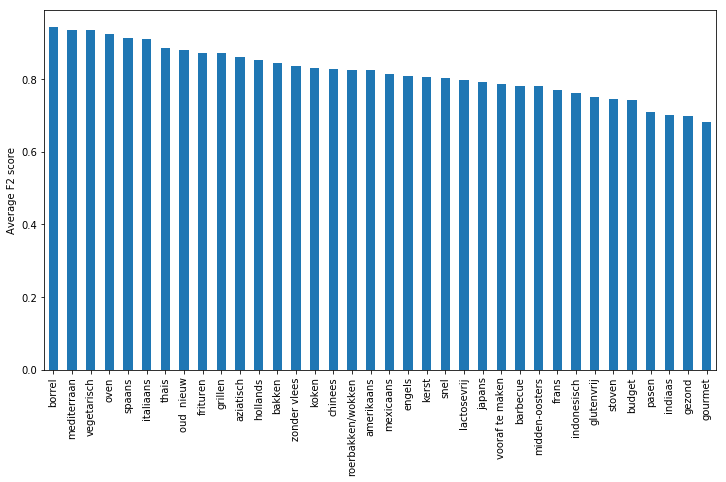

In [88]:
tags = pd.DataFrame(scores)
tags = tags.sort_values(by=1, ascending=False)
tags.plot.bar(x=0, y=1, figsize=(10, 7), legend=None)
#plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlabel("")
plt.ylabel("Average F2 score")
plt.savefig('tag_classifier_score.png', dpi=300)

In [62]:
tags

,0,1
13,zonder vlees,0.836066
24,vooraf te maken,0.785061
2,vegetarisch,0.935678
6,thais,0.886076
30,stoven,0.745902
4,spaans,0.913313
21,snel,0.804176
16,roerbakken/wokken,0.824053
32,pasen,0.709302
3,oven,0.925297


In [33]:
dataset = pd.read_pickle('./data/recipe_dataset.pkl')
recipes_sample = dataset[dataset.type == 'recipes']
predicted_tags = tag_clf.predict(recipes_sample['ocr'])

In [34]:
all_predicted_tags = []
for index in range(predicted_tags.shape[0]):
    all_predicted_tags.append(', '.join(list(mlb.classes_[np.where(predicted_tags[index, :] == 1)[0]])))
for x in all_predicted_tags:
    if x is None:
        x = ''
        
recipes_sample['tags'] = all_predicted_tags

In [99]:
tag_counter = {} 
for tag in mlb.classes_:
    count = recipes_sample[recipes_sample['tags'].str.contains(tag)].shape[0]
    tag_counter[tag] = count

In [107]:
joblib.dump(mlb.classes_, 'models/tag_classes.pkl')

['models/tag_classes.pkl']

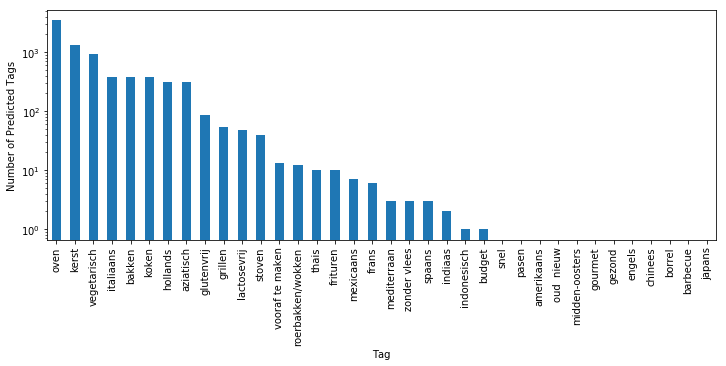

In [105]:
tagz = pd.DataFrame.from_dict(tag_counter, orient='index')
tagz = tagz.sort_values(by=0, ascending=False)
ax = tagz.plot.bar(x=tagz.index, y=0, figsize=(15,10), legend=None)
ax.set_yscale("log", nonposx='clip')
plt.tight_layout()
plt.ylabel("Number of Predicted Tags")
plt.xlabel("Tag")
plt.savefig('Predicted_tags_log.png', dpi=300)

In [ ]:
# Create a sample file for annotating purposes.
#This file contains all tags that appeared less than 100 times. And for those that appear more often a sample of 100 recipes. 

sample_tags = pd.DataFrame()
sample_tags = sample_tags.append(recipes_sample[recipes_sample['tags'].str.len() == 0].sample(100))
for tag in mlb.classes_:
    count = recipes_sample[recipes_sample['tags'].str.contains(tag)].shape[0]
    if count < 100:
        sample_tags = sample_tags.append(recipes_sample[recipes_sample['tags'].str.contains(tag)])
    else:
        sample_tags = sample_tags.append(recipes_sample[recipes_sample['tags'].str.contains(tag)].sample(100))

In [394]:
sample_tags.to_csv('data/sample_tags.csv')

In [395]:
sample_tags.shape

(1197, 8)

## Load annotated Tags

In [39]:
samples_annotated = pd.read_csv('data/sample_tags - annotated.csv', index_col=0)

In [40]:
len(samples_annotated)

1197

### Calculate evaluation metrics

In [41]:
TP_asian = np.where(samples_annotated['predicted_tags'].str.contains('aziatisch') & samples_annotated['annotated_tags'].str.contains('aziatisch'))[0].shape[0]
FN_asian = np.where(~samples_annotated['predicted_tags'].astype(str).str.contains('aziatisch') & samples_annotated['annotated_tags'].str.contains('aziatisch'))[0].shape[0]
FP_asian = np.where(samples_annotated['predicted_tags'].astype(str).str.contains('aziatisch') & ~samples_annotated['annotated_tags'].astype(str).str.contains('aziatisch'))[0].shape[0]
TN_asian = np.where(~samples_annotated['predicted_tags'].astype(str).str.contains('aziatisch') & ~samples_annotated['annotated_tags'].astype(str).str.contains('aziatisch'))[0].shape[0]

precision_asian = TP_asian / (TP_asian + FP_asian)
recall_asian = TP_asian / (TP_asian + FN_asian)
accuracy_asian = (TP_asian + TN_asian) / (TP_asian + TN_asian + FP_asian + FN_asian)
f1_asian = 2 * (precision_asian * recall_asian) / (precision_asian + recall_asian)

In [42]:
print("Precision Asian Tag: {}".format(precision_asian))
print("Recall Asian Tag: {}".format(recall_asian))
print("Accuracy Asian Tag: {}".format(accuracy_asian))
print("F1 Asian Tag: {}".format(f1_asian))

Precision Asian Tag: 0.9738562091503268
Recall Asian Tag: 0.7198067632850241
Accuracy Asian Tag: 0.948203842940685
F1 Asian Tag: 0.8277777777777778


In [43]:
TP_italian = np.where(samples_annotated['predicted_tags'].str.contains('italiaans') & samples_annotated['annotated_tags'].str.contains('italiaans'))[0].shape[0]
FN_italian = np.where(~samples_annotated['predicted_tags'].astype(str).str.contains('italiaans') & samples_annotated['annotated_tags'].str.contains('italiaans'))[0].shape[0]
FP_italian = np.where(samples_annotated['predicted_tags'].astype(str).str.contains('italiaans') & ~samples_annotated['annotated_tags'].astype(str).str.contains('italiaans'))[0].shape[0]
TN_italian = np.where(~samples_annotated['predicted_tags'].astype(str).str.contains('italiaans') & ~samples_annotated['annotated_tags'].astype(str).str.contains('italiaans'))[0].shape[0]

precision_italian = TP_italian / (TP_italian + FP_italian)
recall_italian = TP_italian / (TP_italian + FN_italian)
accuracy_italian = (TP_italian + TN_italian) / (TP_italian + TN_italian + FP_italian + FN_italian)
f1_italian = 2 * (precision_italian * recall_italian) / (precision_italian + recall_italian)

In [44]:
print("Precision Italian Tag: {}".format(precision_italian))
print("Recall Italian Tag: {}".format(recall_italian))
print("Accuracy Italian Tag: {}".format(accuracy_italian))
print("F1 Italian Tag: {}".format(f1_italian))

Precision Italian Tag: 0.8321678321678322
Recall Italian Tag: 0.8439716312056738
Accuracy Italian Tag: 0.9615705931495405
F1 Italian Tag: 0.8380281690140846


In [45]:
TP_vegetarian = np.where(samples_annotated['predicted_tags'].str.contains('vegetarisch') & samples_annotated['annotated_tags'].str.contains('vegetarisch'))[0].shape[0]
FN_vegetarian = np.where(~samples_annotated['predicted_tags'].astype(str).str.contains('vegetarisch') & samples_annotated['annotated_tags'].str.contains('vegetarisch'))[0].shape[0]
FP_vegetarian = np.where(samples_annotated['predicted_tags'].astype(str).str.contains('vegetarisch') & ~samples_annotated['annotated_tags'].astype(str).str.contains('vegetarisch'))[0].shape[0]
TN_vegetarian = np.where(~samples_annotated['predicted_tags'].astype(str).str.contains('vegetarisch') & ~samples_annotated['annotated_tags'].astype(str).str.contains('vegetarisch'))[0].shape[0]

precision_vegetarian = TP_vegetarian / (TP_vegetarian + FP_vegetarian)
recall_vegetarian = TP_vegetarian / (TP_vegetarian + FN_vegetarian)
accuracy_vegetarian = (TP_vegetarian + TN_vegetarian) / (TP_vegetarian + TN_vegetarian + FP_vegetarian + FN_vegetarian)
f1_vegetarian = 2 * (precision_vegetarian * recall_vegetarian) / (precision_vegetarian + recall_vegetarian)

In [46]:
print("Precision vegetarian Tag: {}".format(precision_vegetarian))
print("Recall vegetarian Tag: {}".format(recall_vegetarian))
print("Accuracy vegetarian Tag: {}".format(accuracy_vegetarian))
print("F1 vegetarian Tag: {}".format(f1_vegetarian))

Precision vegetarian Tag: 0.7822222222222223
Recall vegetarian Tag: 0.44556962025316454
Accuracy vegetarian Tag: 0.7761069340016709
F1 vegetarian Tag: 0.567741935483871
